In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import datetime

In [2]:
import nltk
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Raw Data Preparation

### listings

In [ ]:
listings = pd.read_csv('listings.csv')

In [ ]:
listings.columns

### community districts

In [ ]:
# with open('community_district_data.csv') as fp:
#     type_list = list()
#     for line in fp:
#         print(line)
    #data = fp.read

### reviews

In [ ]:
reviews = pd.read_csv('reviews.csv')

In [ ]:
reviews

# Data preprocessing

### dataframe_geography

In [ ]:
df_geo = pd.DataFrame(columns=['listing_id','latitude','longitude',
                           'zipcode','borough'])

df_geo['listing_id'] = listings['id']
df_geo['latitude'] = listings['latitude'].astype('float',copy=False)
df_geo['longitude'] = listings['longitude'].astype('float',copy=False)

In [ ]:
df_geo.columns

In [ ]:
# check values of each col
print(df_geo['longitude'].isnull().sum())
print(df_geo['latitude'].isnull().sum())

# zip code cannot be used because of too many missing values & wrong values
print(df_geo['zipcode'].isnull().sum())

# each listing id is an unique primary key
print(len(df_geo['listing_id'].unique()))

In [ ]:
! pip install uszipcode

In [ ]:
# remap zip code for each row
from uszipcode import SearchEngine
from uszipcode import Zipcode
search = SearchEngine(simple_zipcode=True)

for i in range(len(df_geo)):
    lat = df_geo.loc[i,'latitude']
    lng = df_geo.loc[i,'longitude']
    result = search.by_coordinates(lat, lng, radius=30, returns=1)
    df_geo.loc[i,'zipcode'] = result[0].zipcode

# save zip code data
df_geo.to_csv('dataframe_geography.csv')

In [ ]:
# load and process zipcode-suborough-borough mapping dataframe
df_bor = pd.read_excel('borough.xlsx')
df_bor['zip_list'] = df_bor['zipcode'].astype(str,copy=False).str.split(',')

df_area = pd.DataFrame(columns = ['zipcode','sub_borough','borough'])
for index in range(len(df_bor)):
    a = df_bor.loc[index,'borough']
    b = df_bor.loc[index,'sub_borough']
    for i in range(len(df_bor.loc[index,'zip_list'])):
        c = df_bor.loc[index,'zip_list'][i]
        df_area = df_area.append({'zipcode':c,'sub_borough':b,'borough':a},ignore_index=True)

# save geo_map df
df_area.to_csv('geo_map.csv')

In [ ]:
# join geo dataframe with map dataframe
df_geo = pd.read_csv('dataframe_geography.csv',index_col = ['Unnamed: 0'])
df_map = pd.read_csv('geo_map.csv',index_col = ['Unnamed: 0'])
df_geo.drop('borough',axis=1,inplace=True)
df_geo = df_geo.set_index('zipcode').join(df_map.set_index('zipcode'),on = 'zipcode')

# save new joined dataframe into new geo df
df_geo = df_geo.loc[df_geo['sub_borough'].isnull() == False]
df_geo.to_csv('dataframe_geography.csv')

### df_review

In [ ]:
# drop reviews with no comments
reviews = reviews[reviews['comments'].isnull()==False]
reviews.reset_index(drop=True,inplace=True)

In [ ]:
reviews

In [ ]:
# consolidate reviews
dict_rev = dict()
for i in range(len(reviews)):
    listing_id = reviews.loc[i,'listing_id']
    if dict_rev.get(str(listing_id)) == None:
        dict_rev[str(listing_id)] = reviews.loc[i,'comments']
    else:
        dict_rev[str(listing_id)] = dict_rev[str(listing_id)] + reviews.loc[i,'comments']

In [ ]:
# change dict to dataframe and save
reviews_text = pd.DataFrame.from_dict(dict_rev,orient = 'index',columns = ['review_text'])
reviews_text.to_csv('review_text.csv')

# Sub-borough Based General Analaysis (TBD)

- Number of listings
- Distribution of room-type information
    - ????

## Number of listings per sub-borough

In [ ]:
df_general = pd.read_csv('dataframe_geography.csv',index_col=['Unnamed: 0'])

# group by sub-boroughs
grouped = df_general.groupby(['sub_borough'])

# check number of listings per borough and sub-borough 
listing_num = pd.DataFrame(grouped.size(),columns=['listing_num'])
grouped_df = pd.DataFrame(listing_num)

# Sort dataframe by index value
grouped_df = grouped_df.sort_index()

# Text mining

## Choose text mining data

### prepare sampling data (done)

In [ ]:
# read from prepared data
reviews_text = pd.read_csv('review_text.csv')
df_geo = pd.read_csv('dataframe_geography.csv',index_col = ['Unnamed: 0'])

In [ ]:
# join review texts with geo map
df_review = df_geo.set_index('listing_id').join(reviews_text.set_index('listing_id'),on = 'listing_id')
df_review.drop(labels='index',axis=1,inplace=True)
df_review.reset_index(inplace=True)

# drop listing_id with no reviews
df_review = df_review[df_review['review_text'].isnull()==False]

In [ ]:
df_review.to_csv('review_for_text_mining.csv')

### sampling review_data/sub-borough (done)

In [3]:
df_review = pd.read_csv('review_for_text_mining.csv',index_col=['Unnamed: 0'])
df_review.reset_index(drop=True,inplace=True)

In [4]:
df_review

,listing_id,zipcode,latitude,longitude,sub_borough,borough,review_text
0,2515,10026,40.799205,-73.953676,Central Harlem,Manhattan,Stephanie was a wonderful host! Her apartment ...
1,2539,11218,40.647486,-73.972370,Borough Park,Brooklyn,Great host Nice room for the price. Great neig...
2,3330,11211,40.708558,-73.942362,Greenpoint,Brooklyn,I haven't met Julia but her place is very nice...
3,3831,11238,40.685138,-73.959757,Central Brooklyn,Brooklyn,"lisa is a wonderful, kind and thoughtful host...."
4,5022,10026,40.798514,-73.943991,Central Harlem,Manhattan,Great host with a very cute apartment. Easy an...
5,5099,10017,40.747672,-73.974997,Gramercy Park and Murray Hill,Manhattan,"I had a great experience at Tina's ""True NYC A..."
6,5121,11238,40.686882,-73.955957,Central Brooklyn,Brooklyn,"Simple place, super nice guy.Great guy with a ..."
7,5172,10017,40.744958,-73.974201,Gramercy Park and Murray Hill,Manhattan,Wonderful location--accommadations warm and fr...
8,5178,10018,40.764887,-73.984930,Chelsea and Clinton,Manhattan,"MR. Kasai was a grreat host , very helpful and..."
9,5203,10025,40.801779,-73.967229,Upper West Side,Manhattan,Emmie and her family are exceptional hosts. Th...


In [ ]:
# group by sub-boroughs
grouped_review = df_review.groupby(['borough','sub_borough'])

# check number of listings per borough and sub-borough 
grouped_review.size()

In [5]:
def get_sample_df(df_review,sample_size):
    # initiate sample dataframe
    review_sample_df = pd.DataFrame(columns=df_review.columns)

    # prepare list of sub-boroughs & list count
    sub_bor_list = list(df_review['sub_borough'].unique())
    count_dict = dict()
    for subbor in sub_bor_list:
        count_dict[subbor] = 0

    for i in range(len(df_review)):
        sub_bor = df_review.loc[i,'sub_borough']
        if count_dict[sub_bor] < sample_size:
            review_sample_df = review_sample_df.append(df_review.iloc[i])
            count_dict[sub_bor] += 1
    
    review_sample_df.reset_index(inplace=True,drop=True)
    return review_sample_df

In [6]:
# given sample size per sub-borough
sample_size = 100
review_sample_df = get_sample_df(df_review,sample_size)
review_sample_df.to_csv('review_sample_subborough_df.csv')

### prepare review_text/borough (done)

In [ ]:
review_bor_dict = dict()
#bor_list = ['Manhattan','Brooklyn','Queens','Bronx']
for i in range(len(df_review)):
    if review_bor_dict.get(df_review.loc[i,'borough']) == None:
        review_bor_dict[df_review.loc[i,'borough']] = df_review.loc[i,'review_text']
    else:
        review_bor_dict[df_review.loc[i,'borough']] += df_review.loc[i,'review_text']

review_bor_df = pd.DataFrame.from_dict(review_bor_dict,orient ='index')
review_bor_df.columns = ['review_bor']
review_bor_df.to_csv('review_bor_df.csv')

### clean text and change format of text data into text_list for text analysis (run before analysis)

In [ ]:
# load data review_text per borough
review_bor_df = pd.read_csv('review_bor_df.csv')
review_bor_df.columns = ['borough','review_text']

In [3]:
# review_bor_df to review_bor_list
review_bor_list = []
for i in range(len(review_bor_df)):
    bor = review_bor_df.loc[i,'borough']
    review = review_bor_df.loc[i,'review_text']
    review_bor_list.append((bor,review))

In [8]:
# load sample data review_text per sub-borough
review_sample_df_raw = pd.read_csv('review_sample_subborough_df.csv',index_col=['Unnamed: 0'])
review_sample_df = review_sample_df_raw[['listing_id','review_text']]

# review_sample_df to review_sample_list
review_sample_list = []
for i in range(len(review_sample_df)):
    listing_id = review_sample_df.loc[i,'listing_id']
    review = review_sample_df.loc[i,'review_text']
    
    # text cleaning of review sample data
    review.replace('\n','')
    review.replace('*','')
    review.replace('..','.')
    review.replace('?','')
    review_sample_df.loc[i,'review_text'] = review
        
    review_sample_list.append((listing_id,review))

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Naive sentiment analysis

In [ ]:
# naive sentiment analysis - functions
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        #print(word_list)
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()
from nltk import word_tokenize

def do_pos_neg_sentiment_analysis(positive_words,negative_words,text_list,debug=False):
    results = list()
    for text in text_list:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text[1].decode('utf-8', 'ignore')):
            if word in positive_words:
                if debug:
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((text[0],float(cpos)/len(word_tokenize(text[1].decode('utf-8', 'ignore'))),
                        float(cneg)/len(word_tokenize(text[1].decode('utf-8', 'ignore')))))
    return results

In [140]:
naive_result = do_pos_neg_sentiment_analysis(positive_words,negative_words,review_sample_list,debug=False)
naive_result_df = pd.DataFrame(naive_result,columns=['listing_id','postive','negative'])
naive_result_df.to_csv('naive_sentiment_analysis_result.csv')

## NRC Sentiment Analysis

In [155]:
#preparing the NRC emotion dictionary
nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
count=0
emotion_dict=dict()
with open(nrc,'r') as f:
    all_lines = list()
    for line in f:
        if count < 46:
            count+=1
            continue
        line = line.strip().split('\t')
        if int(line[2]) == 1:
            if emotion_dict.get(line[0]):
                emotion_dict[line[0]].append(line[1])
            else:
                emotion_dict[line[0]] = [line[1]]

def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0

    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in text.split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1.0/len(text.split())
    return emotion_count

In [156]:
# a function that analyzes the emotional content of the review texts
def comparative_emotion_analyzer(text_tuples,object_name="listing_id",print_output=False):
    if print_output:
        print("%-20s %1s\t%1s %1s %1s %1s   %1s %1s %1s %1s"%(object_name,
                                                              "fear","trust","negative","positive",
                                                              "joy","disgust","anticip", "sadness",
                                                              "surprise"))
    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text_tuple in text_tuples:#
        text = text_tuple[1] 
        result = emotion_analyzer(text)
        if print_output:
            print("%-20s %1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f"%(
                text_tuple[1][0:20],result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']))
        df.loc[text_tuple[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output

In [168]:
NRC_result = comparative_emotion_analyzer(review_sample_list)
NRC_result.to_csv('NRC_sentiment_analysis_result.csv')

## Vadar Sentiment Analysis

In [5]:
!pip install vaderSentiment

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
bleach 2.1.4 has requirement html5lib!=1.0b1,!=1.0b2,!=1.0b3,!=1.0b4,!=1.0b5,!=1.0b6,!=1.0b7,!=1.0b8,>=0.99999999pre, but you'll have html5lib 1.0b8 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [18]:
def vader_comparison(col_name,texts):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from nltk import sent_tokenize, word_tokenize
    vadar_df = pd.DataFrame(columns=[col_name,'positive','negative','neutral','compound'])
    analyzer = SentimentIntensityAnalyzer()
    for i in range(len(texts)):
        name = texts[i][0]
        sentences = sent_tokenize(texts[i][1])
        pos=compound=neu=neg=0
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            pos+=vs['pos']/(len(sentences))
            compound+=vs['compound']/(len(sentences))
            neu+=vs['neu']/(len(sentences))
            neg+=vs['neg']/(len(sentences))
        vadar_df = vadar_df.append({col_name:name,'positive':pos,
                                    'negative':neg,'neutral':neu,'compound':compound},ignore_index=True)
    return vadar_df

In [32]:
vadar_result = vader_comparison('listing_id',review_sample_list[:2])
vadar_result.to_csv('vadar_sentiment_analysis_result.csv')

## Word Cloud

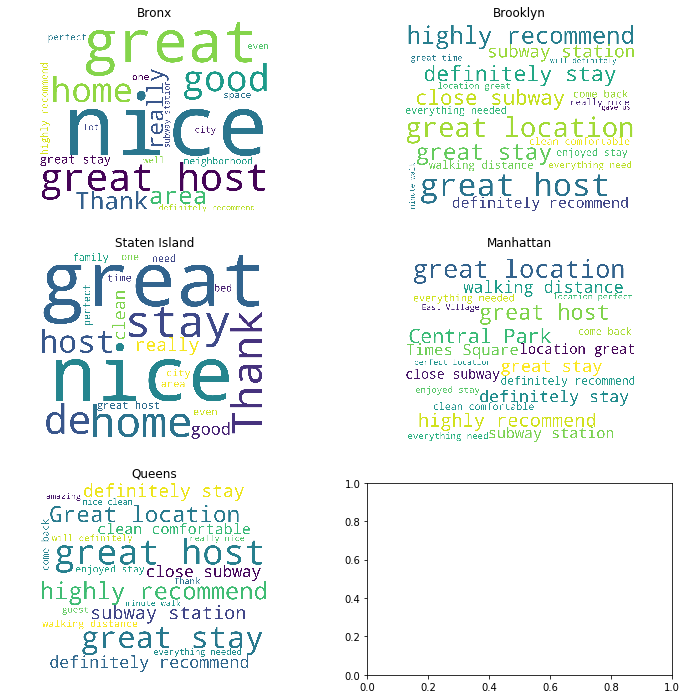

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
#Remove unwanted words
#As we look at the cloud, we can get rid of words that don't make sense by adding them to this variable
DELETE_WORDS = ['room','apartment','house','place','New York','NYC',
                'Staten Island', 'Bronx','Manhattan','Brooklyn','Queens']
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+ word +' ',' ',1)
    return text_string

#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i in range(len(review_bor_list)):
    text_string = remove_words(review_bor_list[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//2, i%2] 
    ax.set_title(review_bor_list[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',
                          width=1200,height=1000,max_words=20).generate(text_string)
    # save wordcloud image to file
    image_name = review_bor_list[i][0] + '_wordcloud.png'
    wordcloud.to_file(image_name)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

## Text mining results analysis

In [51]:
vadar_result_all = pd.read_csv('vadar_all_reviews_result.csv',index_col='Unnamed: 0')

In [52]:
vadar_result_all

,listing_id,positive,negative,neutral,compound
0,2515.0,0.221300,0.019026,0.759676,0.365536
1,2539.0,0.290750,0.009437,0.699812,0.499075
2,3330.0,0.245543,0.008633,0.745824,0.448850
3,3831.0,0.214805,0.018656,0.766537,0.363554
4,5022.0,0.245000,0.005852,0.749148,0.441030
5,5099.0,0.235443,0.030786,0.733761,0.385955
6,5121.0,0.312420,0.012000,0.675586,0.507146
7,5172.0,0.275211,0.016218,0.708561,0.476571
8,5178.0,0.165735,0.037421,0.796850,0.230704
9,5203.0,0.301723,0.013275,0.685004,0.512093


## Machine learning - Borough recommendations

- Classification model based on a list of features of every listings

In [56]:
listings = pd.read_csv('listings.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyError: 0

In [55]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50041 entries, 0 to 50040
Data columns (total 96 columns):
id                                  50041 non-null int64
listing_url                         50041 non-null object
scrape_id                           50041 non-null int64
last_scraped                        50041 non-null object
name                                50018 non-null object
summary                             48185 non-null object
space                               34379 non-null object
description                         49610 non-null object
experiences_offered                 50041 non-null object
neighborhood_overview               29820 non-null object
notes                               19906 non-null object
transit                             31091 non-null object
access                              28928 non-null object
interaction                         27811 non-null object
house_rules                         29879 non-null object
thumbnail_url          

In [53]:
model_df_raw = pd.read_csv('dataframe_geography.csv',index_col=['Unnamed: 0'])
model_df_raw

,index,zipcode,listing_id,latitude,longitude,sub_borough,borough
0,0,10026,2515,40.799205,-73.953676,Central Harlem,Manhattan
1,1,11218,2539,40.647486,-73.972370,Borough Park,Brooklyn
3,3,11211,3330,40.708558,-73.942362,Greenpoint,Brooklyn
4,4,10037,3647,40.809018,-73.941902,Central Harlem,Manhattan
5,5,11238,3831,40.685138,-73.959757,Central Brooklyn,Brooklyn
6,6,10026,5022,40.798514,-73.943991,Central Harlem,Manhattan
7,7,10017,5099,40.747672,-73.974997,Gramercy Park and Murray Hill,Manhattan
8,8,11238,5121,40.686882,-73.955957,Central Brooklyn,Brooklyn
9,9,10017,5172,40.744958,-73.974201,Gramercy Park and Murray Hill,Manhattan
10,10,10018,5178,40.764887,-73.984930,Chelsea and Clinton,Manhattan


In [ ]:
pd.DataFrame(columns=['Borough_id',
                                 'listing_id',])